# Steelplant emission plumes

Sentinel-5P does mesaurements of Carbon monoxide (CO) and Nitrogen dioxide (NO$_2$) which are combustion products. In this example, 
1. Sentinel-5P CO data is extracted based on
    - the year 2024 
    - Geometry: A square piece around a steelplant is defined
    - Cloud mask is filtering is switched on.
2. CO plumes are identified in the extracted data
    - A simple plume detection algorithm in form of an UDF.
    - CO plumes need not necessarily be from the steel plant as it is a long lived gas and can come from other sources. To ensure it is from steelplant, NO$_2$ plume, a short lived gas, at the same location is tested. In steelplants, both CO and NO$_2$ are products of combustion.
3. Load the data from above plume detection and then load NO$_2$ data and find a plume and compute correlation between two plumes to ensure the plume is from steel plant.

In [31]:
import openeo

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
import openeo.processes as eop
import pandas as pd

In [2]:
# authenticate your account
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
def get_extent(lat, lon, delta=1):
    """
    Takes lat, lon and delta (half width of square) and return the square geometry.
    All numbers in lat-lon.
    """
    return {"west":lon-delta, "south":lat-delta, "east": lon+delta, "north": lat+delta}

In [4]:
# matimba = [-23.668490535102727, 27.61198255559957]  # lat-lon
lipstek = [52.60183671287156, 39.603144259343175]
steelplant = lipstek

bbox = get_extent(steelplant[0], steelplant[1])
time = ["2024-01-01", "2025-01-01"]

In [5]:
bbox.values()

dict_values([38.603144259343175, 50.60183671287156, 41.603144259343175, 54.60183671287156])

In [6]:
connection.describe_collection("SENTINEL_5P_L2")

{'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['CO',
    'HCHO',
    'NO2',
    'O3',
    'SO2',
    'CH4',
    'AER_AI_340_380',
    'AER_AI_354_388',
    'CLOUD_BASE_PRESSURE',
    'CLOUD_TOP_PRESSURE',
    'CLOUD_BASE_HEIGHT',
    'CLOUD_TOP_HEIGHT',
    'CLOUD_OPTICAL_THICKNESS',
    'CLOUD_FRACTION',
    'dataMask']},
  't': {'extent': ['2018-04-30T00:18:50Z', None],
   'step': 'P1D',
   'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': 4326,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-85, 85],
   'reference_system': 4326,
   'type': 'spatial'}},
 'description': 'Sentinel 5 Precursor imagery captured by TROPOMI sensor.\n\nThis dataset only supports loading one band at a time.',
 'extent': {'spatial': {'bbox': [[-180.0, -85.0, 180.0, 85.0]]},
  'temporal': {'interval': [['2018-04-30T00:18:50Z', None]]}},
 'id': 'SENTINEL_5P_L2',
 'license': 'proprietary',
 'links': [{'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/',
   'rel': 'root',
   'type': 'application/json'},
  {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2',
   'rel': 'self',
   'type': 'application/json'},
  {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections',
   'rel': 'parent',
   'type': 'application/json'},
  {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2/queryables',
   'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
   'type': 'application/schema+json'},
  {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2/items',
   'rel': 'items',
   'type': 'application/geo+json'}],
 'providers': [],
 'sci:citation': 'Modified Copernicus Sentinel data [Year]/Sentinel Hub',
 'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
  'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
  'https://docs.sentinel-hub.com/api/latest/stac/s5p/v1.0.0/schema.json'],
 'stac_version': '1.0.0',
 'summaries': {'eo:bands': [{'data_type': 'float32',
    'description': 'Carbon monoxide',
    'name': 'CO',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [0.1], 'minimum': [0]}},
   {'data_type': 'float32',
    'description': 'Formaldehyde',
    'name': 'HCHO',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [0.001], 'minimum': [0]}},
   {'data_type': 'float32',
    'description': 'Nitrogen oxide',
    'name': 'NO2',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [0.0003], 'minimum': [0]}},
   {'data_type': 'float32',
    'description': 'Ozone',
    'name': 'O3',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [0.36], 'minimum': [0]}},
   {'data_type': 'float32',
    'description': 'Sulphur dioxide',
    'name': 'SO2',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [0.01], 'minimum': [0]}},
   {'data_type': 'float32',
    'description': 'Methane',
    'name': 'CH4',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [2000], 'minimum': [1600]}},
   {'data_type': 'float32',
    'description': 'UV (Ultraviolet) Aerosol Index calculated based on wavelengths of 340 nm and 380 nm',
    'name': 'AER_AI_340_380',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
    'statistics': {'maximum': [5], 'minimum': [-1]}},
   {'data_type': 'float32',
    'description': 'UV (Ultraviolet) Aerosol Index calculated based on wavelengths of 354 nm and 388 nm',
    'name': 'AER_AI_354_388',
    'openeo:gsd': {'unit': '°',
     'value': [0.054563492063483, 0.034722222222216]},
   

In [5]:
datacube = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=time,
    spatial_extent=bbox,
    bands=["NO2"],
)

In [24]:
datacube.download("lipstek_no2.nc")

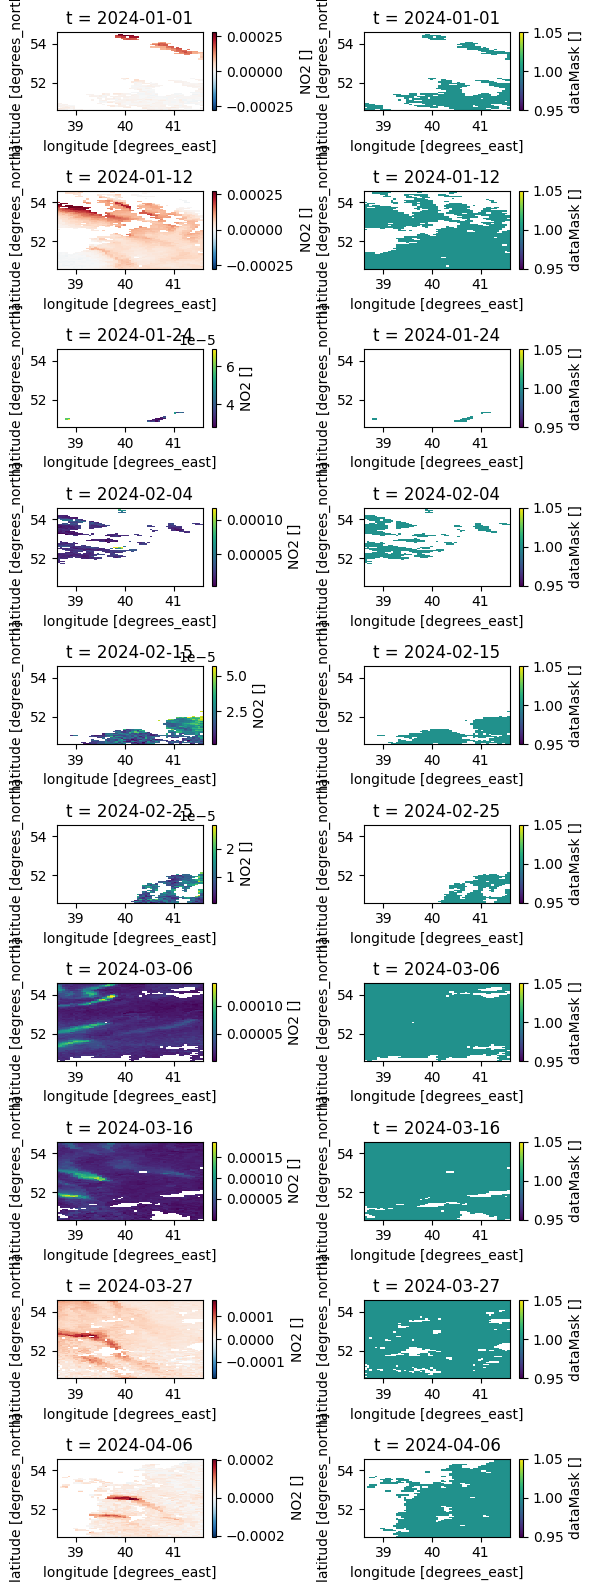

In [31]:
df = xr.load_dataset("lipstek_no2.nc")
fig, axis = plt.subplots(10,2, figsize=(6,16))
for i in range():
    df["NO2"][i*10].plot(ax=axis[i,0])
    df["dataMask"][i*10].plot(ax=axis[i,1])
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

### Compute the number of nans in the data and filter days with the good data

In [6]:
newdata = datacube.apply(lambda x: eop.is_nan(x))
newdata1 = newdata.aggregate_spatial(geometries=box(*bbox.values()), reducer="mean")

newdata1.download("data2.csv", format="CSV")

In [29]:
newdata2 = newdata1.vector_to_raster(datacube)
newdata3 = newdata2.apply(lambda x: eop.lt(x=x, y=0.1))
newdata4 = datacube.mask(mask=newdata3)
newdata4.download("lipstek_no2_filtered.nc")

In [30]:
df1 = xr.load_dataset("lipstek_no2_filtered.nc")
df1

<xarray.Dataset> Size: 3MB
Dimensions:  (t: 347, x: 37, y: 58)
Coordinates:
  * t        (t) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
  * x        (x) float64 296B 38.63 38.68 38.74 38.79 ... 40.49 40.54 40.59
  * y        (y) float64 464B 53.58 53.55 53.52 53.48 ... 51.67 51.64 51.61
Data variables:
    crs      |S1 1B b''
    NO2      (t, y, x) float32 3MB nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [49]:
dd = pd.read_csv("data2.csv")
dd[dd.NO2 < 0.1]

,date,feature_index,NO2
0,2024-05-04T00:00:00.000Z,0,0.079217
14,2024-04-30T00:00:00.000Z,0,0.000000
17,2024-02-03T00:00:00.000Z,0,0.020037
38,2024-05-29T00:00:00.000Z,0,0.000000
54,2024-03-14T00:00:00.000Z,0,0.000932
...,...,...,...
304,2024-05-26T00:00:00.000Z,0,0.012116
309,2024-07-12T00:00:00.000Z,0,0.000932
310,2024-07-13T00:00:00.000Z,0,0.018639
337,2024-03-07T00:00:00.000Z,0,0.000466


In [66]:
np.isnan(df1.sel(t = '2024-05-04T00:00:00.000000000').NO2.values).mean()

np.float64(1.0)

In [26]:
udf = openeo.UDF("""
import xarray
def apply_datacube(cube: xarray.DataArray, context: dict) -> xarray.DataArray:
    return cube[cube < 0.1]
""")
newdata2 = newdata1.apply_dimension(process=udf, dimension="t")

In [27]:
newdata2.download("data3.csv", format="CSV")

OpenEoApiError: [400] ProcessParameterInvalid: The value passed for parameter 'data' in process 'apply_dimension' is invalid: Expected (<class 'openeo_driver.datacube.DriverDataCube'>, <class 'openeo_driver.datacube.DriverVectorCube'>) but got <class 'openeogeotrellis.vectorcube.AggregateSpatialResultCSV'>. (ref: r-2502041044054e398457f4e19c6731ed)

In [97]:

newdata = datacube.aggregate_spatial(geometries=box(*bbox.values()), reducer="mean")

In [99]:
from openeo import processes as eop

In [106]:
# def fun(x: eop.ProcessBuilder):
#      return eop.mean(eop.is_nodata(x))
newdata = datacube.apply(lambda x: eop.is_nan(x))
newdata.download("tmp_mask.nc")

# newdata.aggregate_spatial(geometries=box(*bbox.values()), reducer="mean").download("data1.csv", format="CSV")

In [109]:
dd = xr.DataArray("tmp_mask.nc")

In [104]:
newdata.download("data1.csv", format="CSV")

OpenEoApiError: [400] BadRequest: java.lang.IllegalArgumentException: Unsupported reducer for aggregate_spatial: is_nodata (ref: r-2502031703144c2a9629582c8d19d143)

In [ ]:
s2_bands = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[startdate, enddate],
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=20,
)

In [9]:
connection.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/SentinelMissions/Sentinel2.html#sentinel-2-level-2a-top-of-canopy-toc',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2